This notebook produces a dataset and series of figures which details the ratio of vacant units to unhoused individuals across all US Department of Housing and Urban Development (HUD) Continuum of Care (CoC) areas, as well as the absolute surplus of vacant units. Vacancy continues to be an issue of debate between tenants and houseless advocates, who believe the co-existence of vacancy and houselessness is an indictment of an unjust housing system, and urbanists and housing economists, for whom more vacancy is considered a postitive factor in determining tenants' bargaining power. This data will not help you decide which it is, but it will at least ensure you have access to a nationwide dataset detailing a figure that is pften hotly contended.

Data for the reproduction of this project is freely available online.

HUD CoC Boundary Files: https://www.hudexchange.info/programs/coc/gis-tools/
HUD PIT Homeless Counts by Year: https://www.hudexchange.info/resource/3031/pit-and-hic-data-since-2007/
US Census Bureau American Communities Survey 2019 5-Year vacancy data from: https://www.nhgis.org/

Souce tables from NHGIS:

1.)Total Population
   Universe:    Total population
   Source code: B01003
   NHGIS code:  ALUB
 
2.)Occupancy Status
   Universe:    Housing units
   Source code: B25002
   NHGIS code:  ALZK
 
3.)Vacancy Status
   Universe:    Vacant housing units
   Source code: B25004
   NHGIS code:  ALZV
   
TIGER-LINE Shapefile of US Census Tracts and Counties from: https://www.nhgis.org/
Not uploaded by virtue of thier size.

Census Tract data was aggregated to the CoC scale using the assumption of the equal distribution of phenomenon within the tract, by breaking the tracts according to CoC boundaries, and weighting the contribuiton of each tract's value ot the CoC totals by that proportion.

by: Alexander Ferrer, Los Angeles

In [48]:
import os
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import earthpy as et
import mapclassify

HUDCoC19gdf=gpd.read_file('/Users/alexanderferrer/Downloads/FY19_CoC_National_Bnd.gdb')

In [2]:
vacancydf=pd.read_csv('/Users/alexanderferrer/Downloads/nhgis0030_csv/nhgis0030_ds244_20195_2019_tract.csv')

tractsgdf=gpd.read_file('/Users/alexanderferrer/Downloads/nhgis0029_shape/nhgis0029_shapefile_tl2019_us_tract_2019/US_tract_2019.shp')

In [3]:
tractsgdf.head()

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID NAME  \
0  G0100010020100      01      001  020100  01001020100  201   
1  G0100010020200      01      001  020200  01001020200  202   
2  G0100010020300      01      001  020300  01001020300  203   
3  G0100010020400      01      001  020400  01001020400  204   
4  G0100010020500      01      001  020500  01001020500  205   

           NAMELSAD  MTFCC FUNCSTAT       ALAND   AWATER     INTPTLAT  \
0  Census Tract 201  G5020        S   9817813.0  28435.0  +32.4819591   
1  Census Tract 202  G5020        S   3325680.0   5669.0  +32.4757580   
2  Census Tract 203  G5020        S   5349273.0   9054.0  +32.4740243   
3  Census Tract 204  G5020        S   6384276.0   8408.0  +32.4710304   
4  Census Tract 205  G5020        S  11408866.0  43534.0  +32.4589224   

       INTPTLON    Shape_Leng    Shape_Area  \
0  -086.4913377  16193.868956  9.846249e+06   
1  -086.4724678   9829.609817  3.331344e+06   
2  -086.4597033  10519.640477  5.358329e+06   
3  -086.4448353  12521.196108  6.392680e+06   
4  -086.4218265  17133.746586  1.145240e+07   

                                            geometry  
0  POLYGON ((888437.995 -515917.537, 888435.804 -...  
1  POLYGON ((889844.072 -519142.061, 889844.876 -...  
2  POLYGON ((891383.841 -518871.184, 891367.251 -...  
3  POLYGON ((892527.268 -516528.670, 892531.715 -...  
4  POLYGON ((895450.953 -522533.363, 895428.322 -...

In [4]:
tractsgdf=tractsgdf.to_crs('EPSG:3857')

In [5]:
tractsgdf["area_before"] = tractsgdf['geometry'].area/ 10**6

In [6]:
vacancydf=vacancydf[['GISJOIN',"ALUBE001","ALZKE001","ALZKE002","ALZKE003",'ALZVE001', 'ALZVE002',
                     'ALZVE003', 'ALZVE004', 'ALZVE005', 'ALZVE006', 'ALZVE007', 'ALZVE008']]

cols_to_rename= {
    
    "ALUBE001":    "Total Population",
    "ALZKE001":    "Total units",
    "ALZKE002":    "Occupied units",
    "ALZKE003":    "Vacant units",
    "ALZVE001":    "Total vacant",
    "ALZVE002":    "For rent",
    "ALZVE003":    "Rented, not occupied",
    "ALZVE004":    "For sale only",
    "ALZVE005":    "Sold, not occupied",
    "ALZVE006":    "For seasonal, recreational, or occasional use",
    "ALZVE007":    "For migrant workers",
    "ALZVE008":    "Other vacant",
}

vacancydf.rename(columns=cols_to_rename,
          inplace=True)

In [7]:
tractsgdf=tractsgdf.set_index('GISJOIN')
vacancydf=vacancydf.set_index('GISJOIN')

In [8]:
jointractsgdf=tractsgdf.join(vacancydf, on='GISJOIN', how='left', rsuffix='_R')

In [9]:
jointractsgdf.head()

STATEFP COUNTYFP TRACTCE        GEOID NAME          NAMELSAD  \
GISJOIN                                                                       
G0100010020100      01      001  020100  01001020100  201  Census Tract 201   
G0100010020200      01      001  020200  01001020200  202  Census Tract 202   
G0100010020300      01      001  020300  01001020300  203  Census Tract 203   
G0100010020400      01      001  020400  01001020400  204  Census Tract 204   
G0100010020500      01      001  020500  01001020500  205  Census Tract 205   

                MTFCC FUNCSTAT       ALAND   AWATER  ... Occupied units  \
GISJOIN                                              ...                  
G0100010020100  G5020        S   9817813.0  28435.0  ...            709   
G0100010020200  G5020        S   3325680.0   5669.0  ...            688   
G0100010020300  G5020        S   5349273.0   9054.0  ...           1360   
G0100010020400  G5020        S   6384276.0   8408.0  ...           1675   
G0100010020500  G5020        S  11408866.0  43534.0  ...           4483   

               Vacant units  Total vacant  For rent Rented, not occupied  \
GISJOIN                                                                    
G0100010020100           16            16         0                    0   
G0100010020200          152           152        46                    0   
G0100010020300           68            68         0                   33   
G0100010020400          188           188        50                    0   
G0100010020500          139           139         0                   37   

                For sale only  Sold, not occupied  \
GISJOIN                                             
G0100010020100              0                   0   
G0100010020200              0                  15   
G0100010020300              2                   0   
G0100010020400             25                   0   
G0100010020500             34                   0   

                For seasonal, recreational, or occasional use  \
GISJOIN                                                         
G0100010020100                                              0   
G0100010020200                                              0   
G0100010020300                                              0   
G0100010020400                                              0   
G0100010020500                                              0   

                For migrant workers  Other vacant  
GISJOIN                                            
G0100010020100                    0            16  
G0100010020200                    0            91  
G0100010020300                    0            33  
G0100010020400                    0           113  
G0100010020500                    0            68  

[5 rows x 28 columns]

In [10]:
jointractsgdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

data_path = os.path.join("data", "spatial-vector-lidar")

sjer_aoi = gpd.read_file(os.path.join(data_path, "california" , 
                                      "neon-sjer-site", 
                                      "vector_data", "SJER_crop.shp"))

country_boundary_us = gpd.read_file(os.path.join(data_path, "usa", 
                                                 "usa-boundary-dissolved.shp"))



Extracted output to /Users/alexanderferrer/earth-analytics/data/spatial-vector-lidar/.


In [38]:
country_boundary_us=country_boundary_us.to_crs('EPSG:3857')

In [39]:
aoi_bounds = sjer_aoi.geometry.total_bounds

Let's quickly look at the geography of vacancy across US Counties first.

In [142]:
jointractsgdf1=jointractsgdf[['COUNTYFP','STATEFP','Total units','Total vacant']]
jointractsgdf1['COUNTYFP']=jointractsgdf1['COUNTYFP'].astype(str)
jointractsgdf1['STATEFP']=jointractsgdf1['STATEFP'].astype(str)

<ipython-input-142-2c59c7f73555>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jointractsgdf1['COUNTYFP']=jointractsgdf1['COUNTYFP'].astype(str)
<ipython-input-142-2c59c7f73555>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jointractsgdf1['STATEFP']=jointractsgdf1['STATEFP'].astype(str)


In [143]:
jointractsgdf1['COUNTY']=jointractsgdf1['STATEFP']+jointractsgdf1['COUNTYFP']

<ipython-input-143-73842c2c5eca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jointractsgdf1['COUNTY']=jointractsgdf1['STATEFP']+jointractsgdf1['COUNTYFP']


In [144]:
countydf=jointractsgdf1.groupby('COUNTY')[['Total units','Total vacant']].sum()

In [145]:
countydf

Total units  Total vacant
COUNTY                           
01001         23493          2096
01003        114164         33234
01005         12013          2668
01007          9185          2294
01009         24323          3476
...             ...           ...
72145         24612          5891
72147          4908          2650
72149          9270          1362
72151         14509          2968
72153         17521          6531

[3220 rows x 2 columns]

In [146]:
countygdf=gpd.read_file('/Users/alexanderferrer/Downloads/tl_2019_us_county/tl_2019_us_county.shp')

In [147]:
countygdf=countygdf.to_crs('EPSG:3857')

In [128]:
countygdf['STATEFP']=countygdf['STATEFP'].astype(str)
countygdf['STATEFP']=countygdf['STATEFP'].astype(str)

In [134]:
countygdf['COUNTY']=countygdf['STATEFP']+countygdf['COUNTYFP']
countygdf.head()

COUNTYFP STATEFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      039      31  00835841  31039     Cuming     Cuming County   06      H1   
1      069      53  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      011      35  00933054  35011    De Baca    De Baca County   06      H1   
3      109      31  00835876  31109  Lancaster  Lancaster County   06      H1   
4      129      31  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477652222  10690952  +41.9158651   
1  G4020  None   None     None        A   680962890  61582307  +46.2946377   
2  G4020  None   None     None        A  6016819475  29089486  +34.3592729   
3  G4020   339  30700     None        A  2169270569  22849484  +40.7835474   
4  G4020  None   None     None        A  1489645188   1718484  +40.1764918   

       INTPTLON                                           geometry COUNTY  
0  -096.7885168  POLYGON ((-10800163.090 5161592.919, -10800163...  31039  
1  -123.4244583  POLYGON ((-13740876.750 5818602.374, -13742123...  53069  
2  -104.3686961  POLYGON ((-11640388.357 4028474.982, -11640425...  35011  
3  -096.6886584  POLYGON ((-10788055.444 4980672.174, -10788055...  31109  
4  -098.0468422  POLYGON ((-10939774.597 4878941.797, -10939774...  31129

In [135]:
countygdf=countygdf.set_index('COUNTY')

In [137]:
countyjoingdf=countygdf.join(countydf, on='COUNTY', how='left', rsuffix='_dat')
countyjoingdf.head()

COUNTYFP STATEFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD  \
COUNTY                                                                       
31039       039      31  00835841  31039     Cuming     Cuming County   06   
53069       069      53  01513275  53069  Wahkiakum  Wahkiakum County   06   
35011       011      35  00933054  35011    De Baca    De Baca County   06   
31109       109      31  00835876  31109  Lancaster  Lancaster County   06   
31129       129      31  00835886  31129   Nuckolls   Nuckolls County   06   

       CLASSFP  MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER  \
COUNTY                                                                       
31039       H1  G4020  None   None     None        A  1477652222  10690952   
53069       H1  G4020  None   None     None        A   680962890  61582307   
35011       H1  G4020  None   None     None        A  6016819475  29089486   
31109       H1  G4020   339  30700     None        A  2169270569  22849484   
31129       H1  G4020  None   None     None        A  1489645188   1718484   

           INTPTLAT      INTPTLON  \
COUNTY                              
31039   +41.9158651  -096.7885168   
53069   +46.2946377  -123.4244583   
35011   +34.3592729  -104.3686961   
31109   +40.7835474  -096.6886584   
31129   +40.1764918  -098.0468422   

                                                 geometry  Total units  \
COUNTY                                                                   
31039   POLYGON ((-10800163.090 5161592.919, -10800163...       4240.0   
53069   POLYGON ((-13740876.750 5818602.374, -13742123...       2149.0   
35011   POLYGON ((-11640388.357 4028474.982, -11640425...       1092.0   
31109   POLYGON ((-10788055.444 4980672.174, -10788055...     131099.0   
31129   POLYGON ((-10939774.597 4878941.797, -10939774...       2445.0   

        Total vacant  
COUNTY                
31039          513.0  
53069          252.0  
35011          420.0  
31109         6775.0  
31129          578.0

In [138]:
countyjoingdf['Vacancy rate']=(countyjoingdf['Total vacant']/countyjoingdf["Total units"])*100

(2814226.091170268, 6340332.343706039)

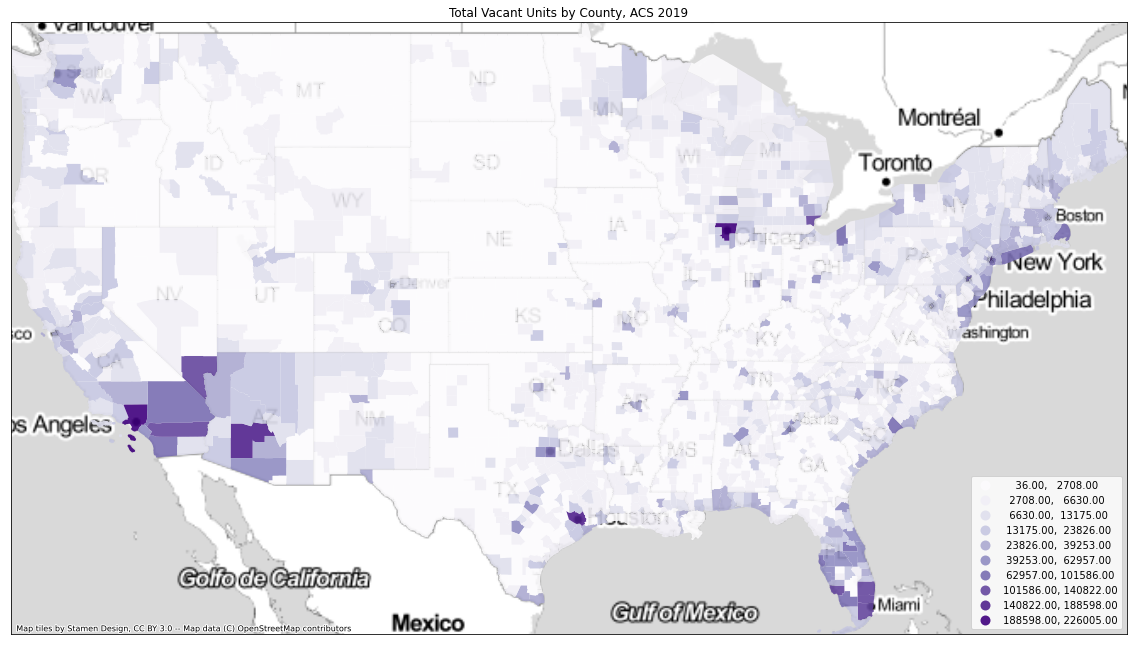

In [139]:
fig, ax = plt.subplots(figsize=(20,20))

countyjoingdf.plot('Total vacant',ax=ax, scheme="natural_breaks", k=10, cmap='Purples', alpha=0.9, legend=True,legend_kwds={'loc': 'lower right'})

plt.title('Total Vacant Units by County, ACS 2019')

ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

xlim = ([country_boundary_us.total_bounds[0],  country_boundary_us.total_bounds[2]])
ylim = ([country_boundary_us.total_bounds[1],  country_boundary_us.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

It should not surprise us to see the raw and absolute totals of vacany units are highest in densely populated counties, as that's where most of the units are. It is simply not true that all of the countries vacancies are in far flung regions.

(2814226.091170268, 6340332.343706039)

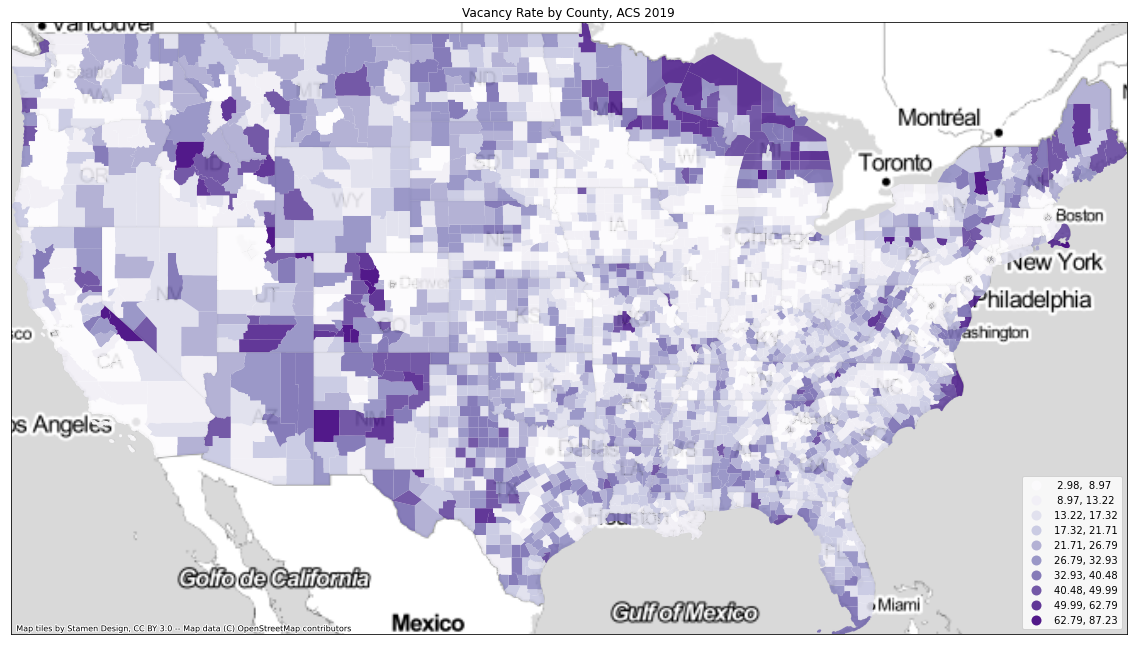

In [141]:
fig, ax = plt.subplots(figsize=(20,20))

countyjoingdf.plot('Vacancy rate',ax=ax, scheme="natural_breaks", k=10, cmap='Purples', alpha=0.9, legend=True,legend_kwds={'loc': 'lower right'})

plt.title('Vacancy Rate by County, ACS 2019')

ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

xlim = ([country_boundary_us.total_bounds[0],  country_boundary_us.total_bounds[2]])
ylim = ([country_boundary_us.total_bounds[1],  country_boundary_us.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

Vacancy rates, of course, are a very different story and are higher in more remote and less dynamic regions. 

In [56]:
HUDCoC19gdf=HUDCoC19gdf.to_crs('EPSG:3857')

In [57]:
sjoingdf=gpd.sjoin(jointractsgdf,HUDCoC19gdf, how="inner")

In [58]:
sjoingdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Shape_Leng',
       'Shape_Area_left', 'geometry', 'area_before', 'Total Population',
       'Total units', 'Occupied units', 'Vacant units', 'Total vacant',
       'For rent', 'Rented, not occupied', 'For sale only',
       'Sold, not occupied', 'For seasonal, recreational, or occasional use',
       'For migrant workers', 'Other vacant', 'index_right', 'ST',
       'STATE_NAME', 'COCNUM', 'COCNAME', 'Shape_Length', 'Shape_Area_right'],
      dtype='object')

In [59]:
sjoingdf["area_after"] = sjoingdf['geometry'].area/ 10**6
sjoingdf["part_tract"]=sjoingdf["area_after"]/sjoingdf["area_before"]

In [60]:
sjoindf=sjoingdf[['Total Population','Total units','Occupied units','Vacant units',
                  'Total vacant', 'For rent', 'Rented, not occupied','For sale only', 'Sold, not occupied',
                  'Other vacant', 'Shape_Length', 'Shape_Area_right',"area_before",
                  'area_after', 'part_tract','COCNUM','COCNAME']]

In [61]:
vacancy_stats=['Total Population','Total units','Occupied units','Vacant units',
               'Total vacant', 'For rent', 'Rented, not occupied','For sale only', 
               'Sold, not occupied','Other vacant']

for stat in vacancy_stats:
    sjoindf[stat]=sjoindf[stat]*sjoindf["part_tract"]

<ipython-input-61-6839cb68dd0b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sjoindf[stat]=sjoindf[stat]*sjoindf["part_tract"]


In [62]:
aggdf=sjoindf.groupby('COCNUM')[['Total Population','Total units','Occupied units','Vacant units',
                  'Total vacant', 'For rent', 'Rented, not occupied','For sale only', 'Sold, not occupied',
                  'Other vacant']].sum()

In [63]:
pitcoutsdf=pd.read_csv('/Users/alexanderferrer/Desktop/2019_PIT_ESTIMATE_CoC.csv')

In [64]:
pitcoutsdf=pitcoutsdf.set_index('COCNUM')

In [65]:
finaldf=aggdf.join(pitcoutsdf, how='left', on='COCNUM', rsuffix="_pit")

In [66]:
finaldf['Unsheltered Homeless, 2019']=finaldf['Unsheltered Homeless, 2019'].astype(float)
finaldf['Overall Homeless, 2019']=finaldf['Overall Homeless, 2019'].astype(float)

In [70]:
finaldf['Vacant per total homeless']=finaldf['Total vacant']/finaldf['Overall Homeless, 2019']

finaldf['Vacant per total unsheltered homeless']=finaldf['Total vacant']/finaldf['Unsheltered Homeless, 2019']

finaldf['Absolute diff vacancy and total homeless']=finaldf['Total vacant']-finaldf['Overall Homeless, 2019']

finaldf['Absolute diff vacancy and total unsheltered homeless']=finaldf['Total vacant']-finaldf['Unsheltered Homeless, 2019']

finaldf['Vacancy rate']=(finaldf['Total vacant']/finaldf["Total units"])*100

In [71]:
finaldf.columns

Index(['Total Population', 'Total units', 'Occupied units', 'Vacant units',
       'Total vacant', 'For rent', 'Rented, not occupied', 'For sale only',
       'Sold, not occupied', 'Other vacant', 'COCNAME',
       'Overall Homeless, 2019', 'Unsheltered Homeless, 2019',
       'Vacant per total homeless', 'Vacant per total unsheltered homeless',
       'Absolute diff vacancy and total homeless',
       'Absolute diff vacancy and total unsheltered homeless', 'Vacancy rate'],
      dtype='object')

In [72]:
print(len(finaldf))

394


In [73]:
finaldf.to_csv("/Users/alexanderferrer/Desktop/finaldf.csv")

In [74]:
mapgdf=HUDCoC19gdf.join(finaldf, on='COCNUM', how='left', rsuffix='_dat')

In [75]:
mapgdf['new_area_sqkm']=mapgdf['geometry'].area/ 10**6

mapgdf['Vacant per km2']=mapgdf['Total vacant']/mapgdf['Total Population']

mapgdf['Homeless per km2']=mapgdf['Overall Homeless, 2019']/mapgdf['Total Population']

mapgdf['Unsheltered homeless per km2']=mapgdf['Unsheltered Homeless, 2019']/mapgdf['Total Population']


mapgdf['Vacant per 1k']=(mapgdf['Total vacant']/mapgdf['Total Population'])*1000

mapgdf['Part Homeless per 1k']=(mapgdf['Overall Homeless, 2019']/mapgdf['Total Population'])*1000

mapgdf['Part unsheltered homeless per 1k']=(mapgdf['Unsheltered Homeless, 2019']/mapgdf['Total Population'])*1000



In [76]:
mapgdf.to_file("/Users/alexanderferrer/Desktop/finalgdf.geojson", driver='GeoJSON')

Now that our data is set up let's take a look.

(2814226.091170268, 6340332.343706039)

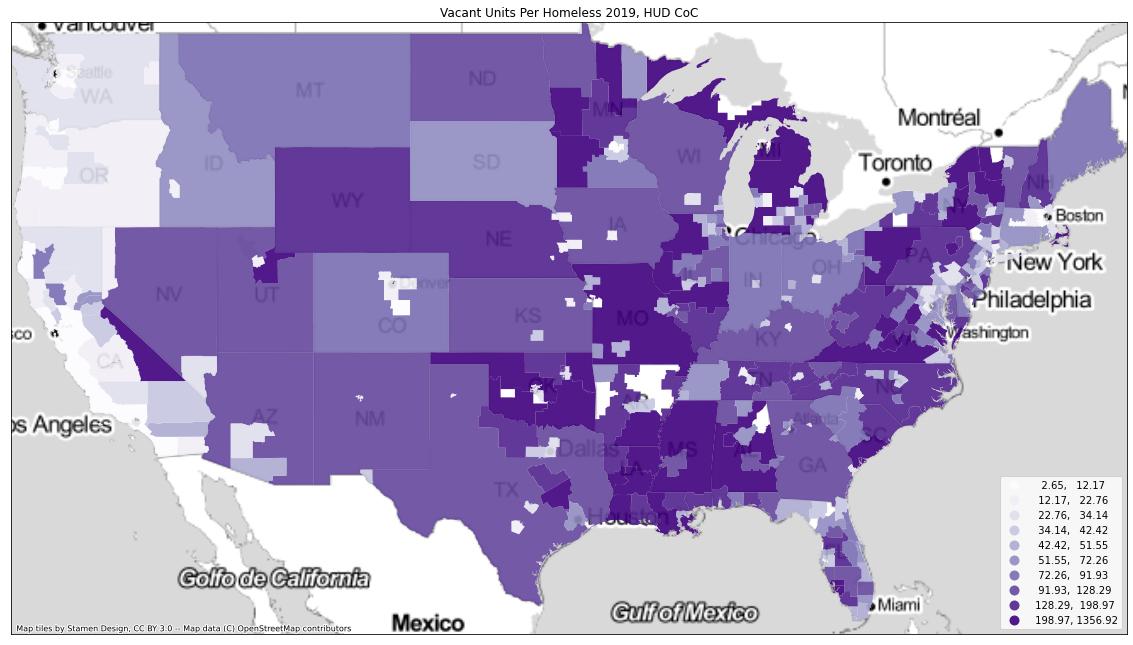

In [80]:
fig, ax = plt.subplots(figsize=(20,20))

mapgdf.plot('Vacant per total homeless',ax=ax, scheme="Quantiles", k=10, cmap='Purples', alpha=0.9, legend=True,legend_kwds={'loc': 'lower right'})

plt.title('Vacant Units Per Homeless 2019, HUD CoC')

ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

xlim = ([country_boundary_us.total_bounds[0],  country_boundary_us.total_bounds[2]])
ylim = ([country_boundary_us.total_bounds[1],  country_boundary_us.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)



In no place are there less vacant homes than unhouesd persons, and the ratio between the two is not lower than 2.65 to 1 in any CoC. Unsurprisingly, the ratio is lowest in places where there are the most unhoused persons, however.

(2814226.091170268, 6340332.343706039)

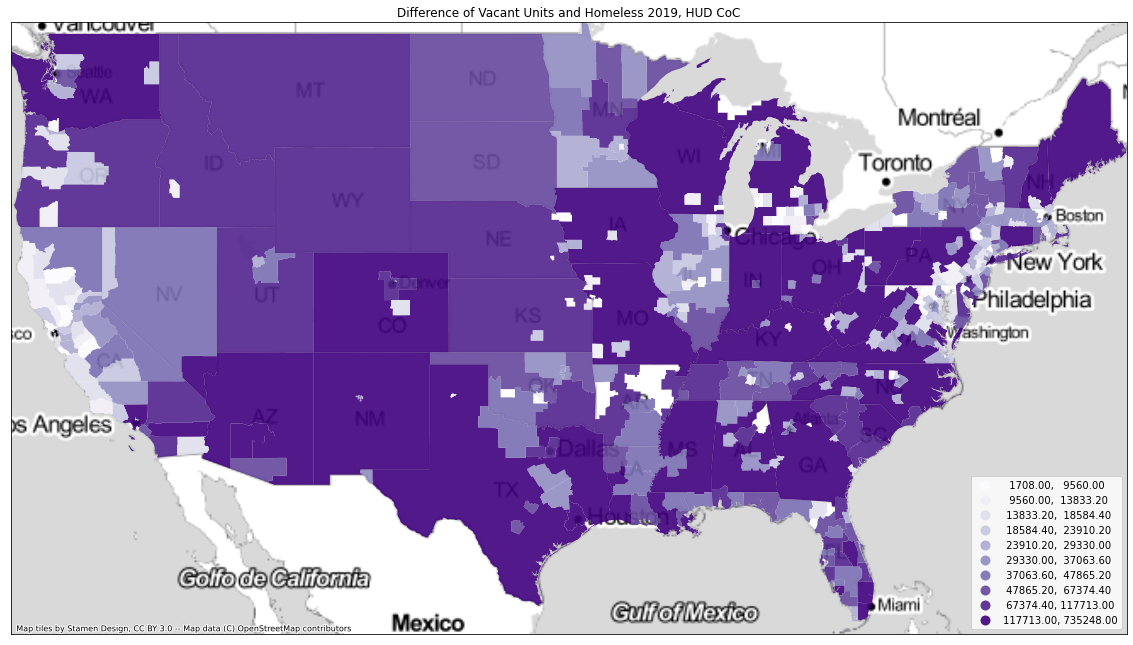

In [81]:
fig, ax = plt.subplots(figsize=(20,20))

mapgdf.plot('Absolute diff vacancy and total homeless',ax=ax, scheme="Quantiles", k=10, cmap='Purples', alpha=0.9, legend=True, legend_kwds={'loc': 'lower right'})

plt.title('Difference of Vacant Units and Homeless 2019, HUD CoC')

ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

xlim = ([country_boundary_us.total_bounds[0],  country_boundary_us.total_bounds[2]])
ylim = ([country_boundary_us.total_bounds[1],  country_boundary_us.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

That being said, the absolute differnce, or the absolute surplus of vacant units relative to unhoused persons is highest in those places, because that's where a lot of units are!

<AxesSubplot:>

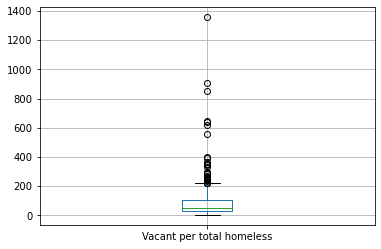

In [82]:
finaldf.boxplot('Vacant per total homeless')

In [83]:
finaldf['Vacant per total homeless'].describe()

count     385.000000
mean       91.217213
std       125.641363
min         2.650242
25%        29.100865
50%        51.550336
75%       105.138191
max      1356.916667
Name: Vacant per total homeless, dtype: float64

<AxesSubplot:>

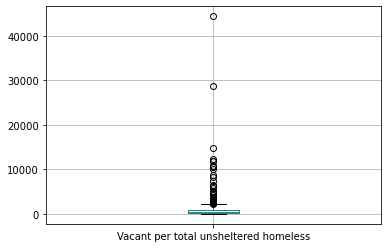

In [84]:
finaldf.boxplot('Vacant per total unsheltered homeless')

In [85]:
finaldf['Vacant per total unsheltered homeless'].describe()

count    385.000000
mean            inf
std             NaN
min        4.551123
25%      115.545455
50%      329.686047
75%      943.384615
max             inf
Name: Vacant per total unsheltered homeless, dtype: float64

<AxesSubplot:>

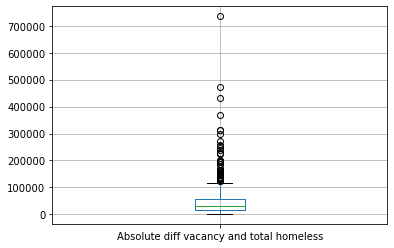

In [86]:
finaldf.boxplot('Absolute diff vacancy and total homeless')

In [87]:
finaldf['Absolute diff vacancy and total homeless'].describe()

count       385.000000
mean      52676.579221
std       71633.968926
min        1708.000000
25%       15992.000000
50%       29330.000000
75%       57918.000000
max      735248.000000
Name: Absolute diff vacancy and total homeless, dtype: float64

<AxesSubplot:>

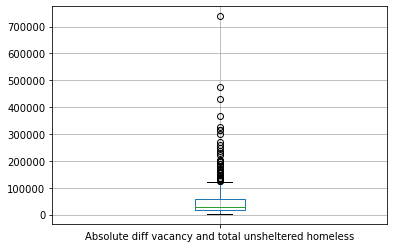

In [88]:
finaldf.boxplot('Absolute diff vacancy and total unsheltered homeless')

(2814226.091170268, 6340332.343706039)

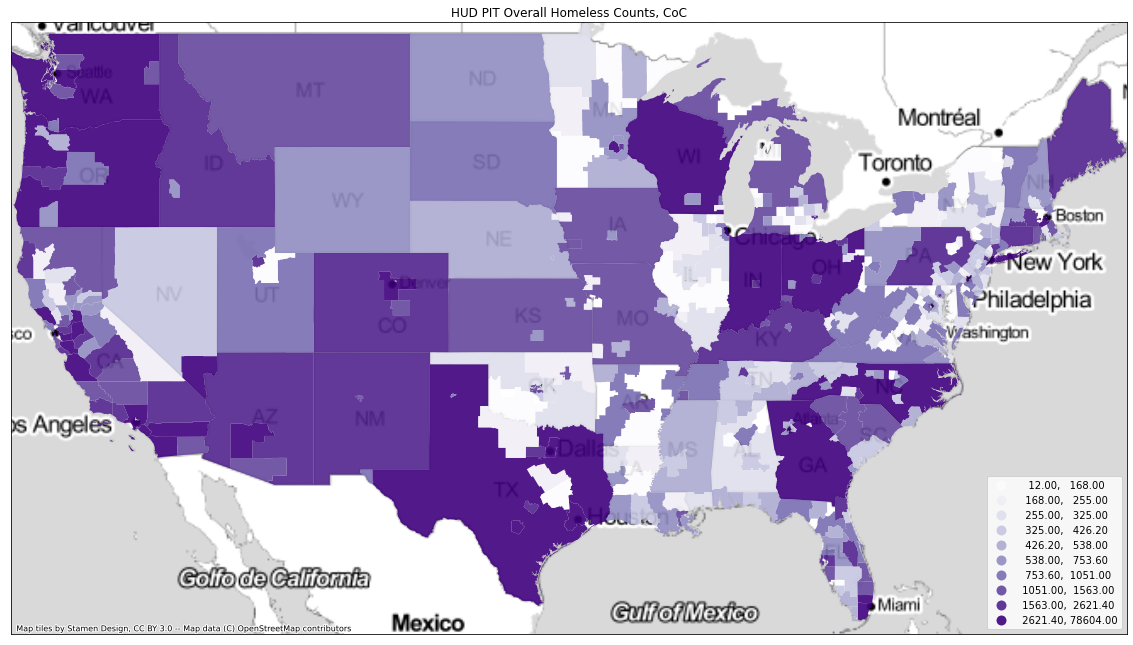

In [91]:
fig, ax = plt.subplots(figsize=(20,20))

mapgdf.plot('Overall Homeless, 2019',ax=ax, scheme="Quantiles", k=10, cmap='Purples', alpha=0.9, legend=True,legend_kwds={'loc': 'lower right'})

plt.title('HUD PIT Overall Homeless Counts, CoC')

ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

xlim = ([country_boundary_us.total_bounds[0],  country_boundary_us.total_bounds[2]])
ylim = ([country_boundary_us.total_bounds[1],  country_boundary_us.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

(2814226.091170268, 6340332.343706039)

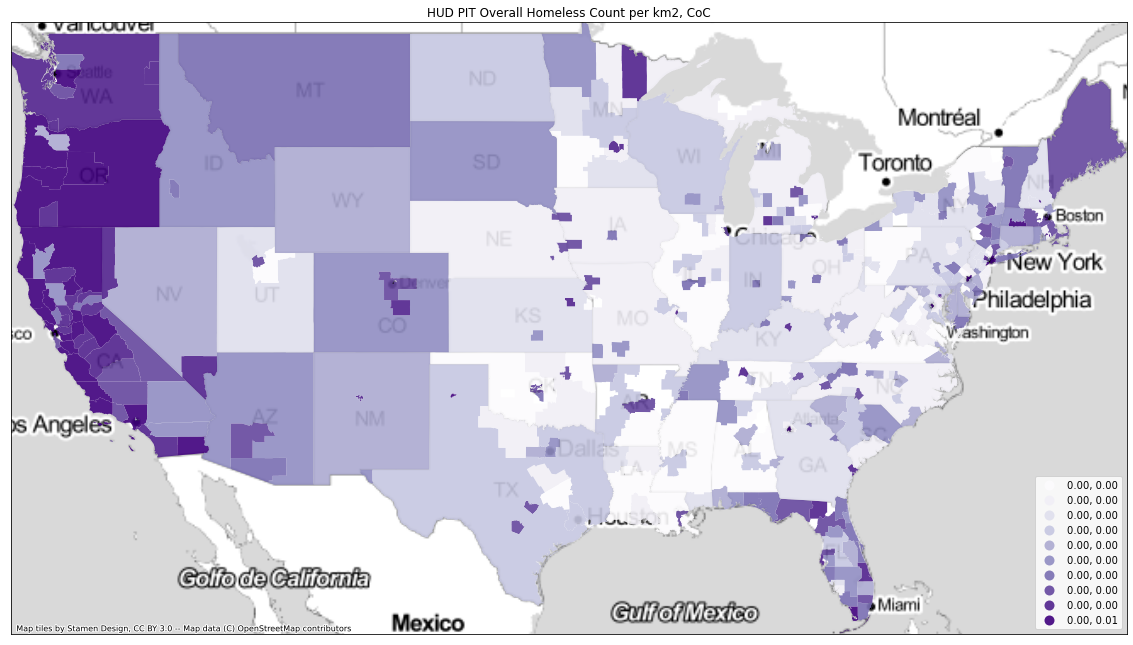

In [92]:
fig, ax = plt.subplots(figsize=(20,20))

mapgdf.plot('Homeless per km2',ax=ax, scheme="Quantiles", k=10, cmap='Purples', alpha=0.9, legend=True,legend_kwds={'loc': 'lower right'})

plt.title('HUD PIT Overall Homeless Count per km2, CoC')

ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

xlim = ([country_boundary_us.total_bounds[0],  country_boundary_us.total_bounds[2]])
ylim = ([country_boundary_us.total_bounds[1],  country_boundary_us.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

(2814226.091170268, 6340332.343706039)

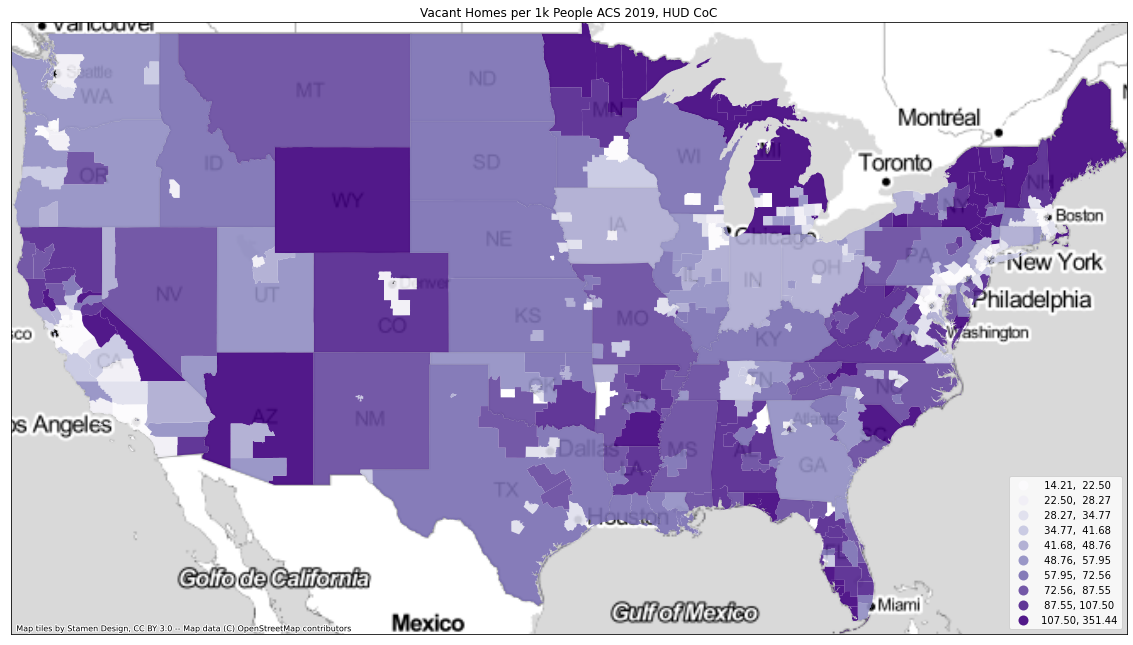

In [93]:
fig, ax = plt.subplots(figsize=(20,20))

mapgdf.plot('Vacant per 1k',ax=ax, scheme="Quantiles", k=10, cmap='Purples', alpha=0.9,legend=True,legend_kwds={'loc': 'lower right'})

plt.title('Vacant Homes per 1k People ACS 2019, HUD CoC')

ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

xlim = ([country_boundary_us.total_bounds[0],  country_boundary_us.total_bounds[2]])
ylim = ([country_boundary_us.total_bounds[1],  country_boundary_us.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

(2814226.091170268, 6340332.343706039)

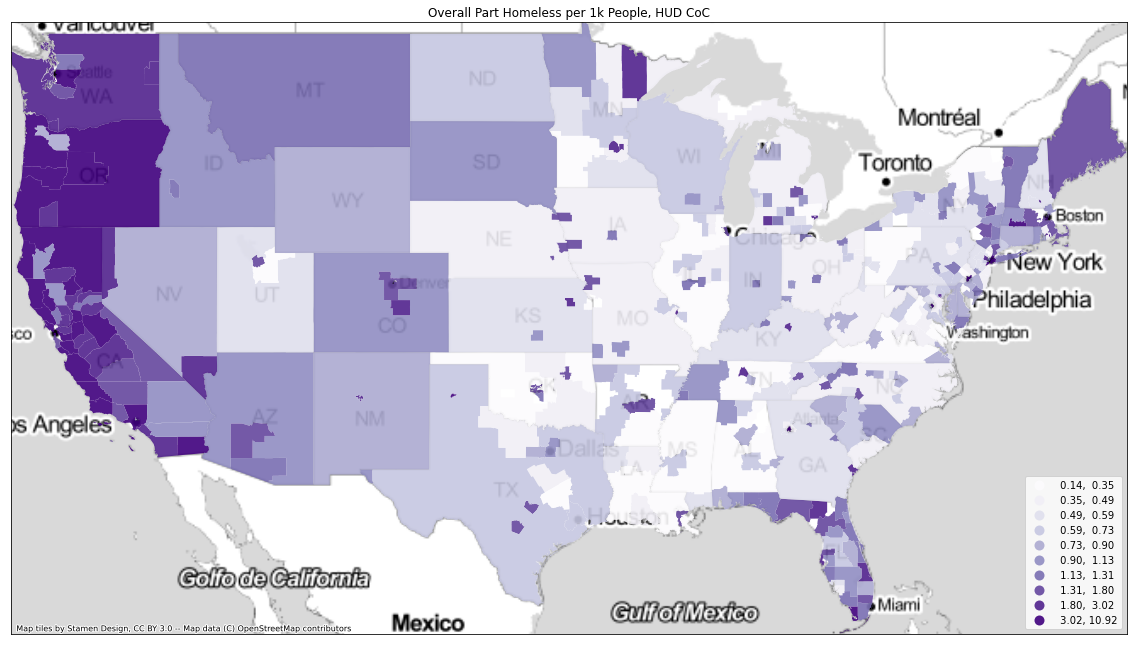

In [94]:
fig, ax = plt.subplots(figsize=(20,20))

mapgdf.plot('Part Homeless per 1k',ax=ax, scheme="Quantiles", k=10, cmap='Purples', alpha=0.9, legend=True,legend_kwds={'loc': 'lower right'})

plt.title('Overall Part Homeless per 1k People, HUD CoC')

ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

xlim = ([country_boundary_us.total_bounds[0],  country_boundary_us.total_bounds[2]])
ylim = ([country_boundary_us.total_bounds[1],  country_boundary_us.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

It is quite evident that there are mor vacant homes than unhoused persons everywhere, and the magnitude of the difference is bigger in some high cost places like LA, the ratios, however (again all above 1:1) are lower int he high cost places with more unhoused residents- this suggests vacancy is not causally linked to houselessness and may even have a negative relationship. 

Within the State of California, where much attention is paid to this issue we can do the same excercise:

In [96]:
calmapgdf=mapgdf[mapgdf['STATE_NAME']=='California']

[]

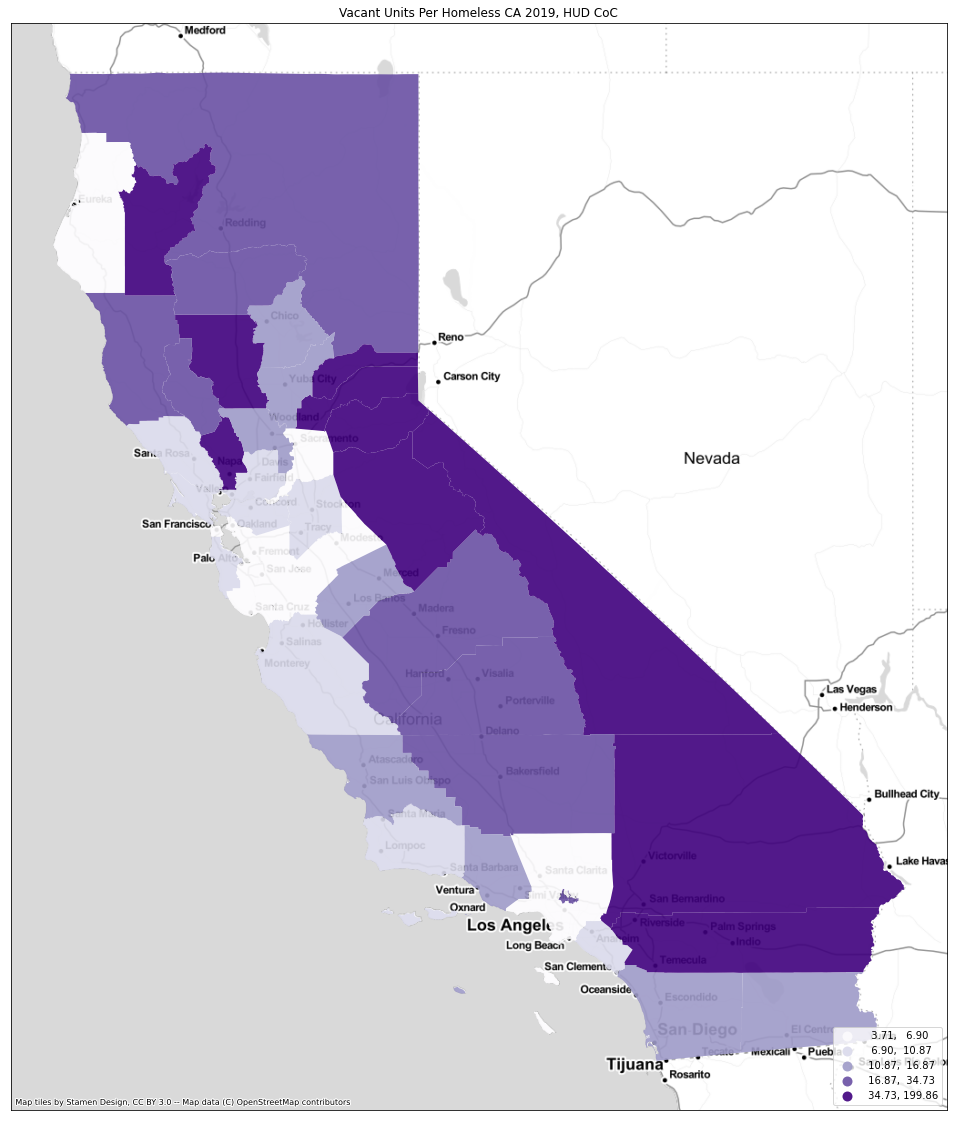

In [99]:
fig, ax = plt.subplots(figsize=(20,20))

calmapgdf.plot('Vacant per total homeless',ax=ax, scheme="Quantiles", k=5 ,cmap='Purples', alpha=0.9, legend=True,legend_kwds={'loc': 'lower right'})

plt.title('Vacant Units Per Homeless CA 2019, HUD CoC')

ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

[]

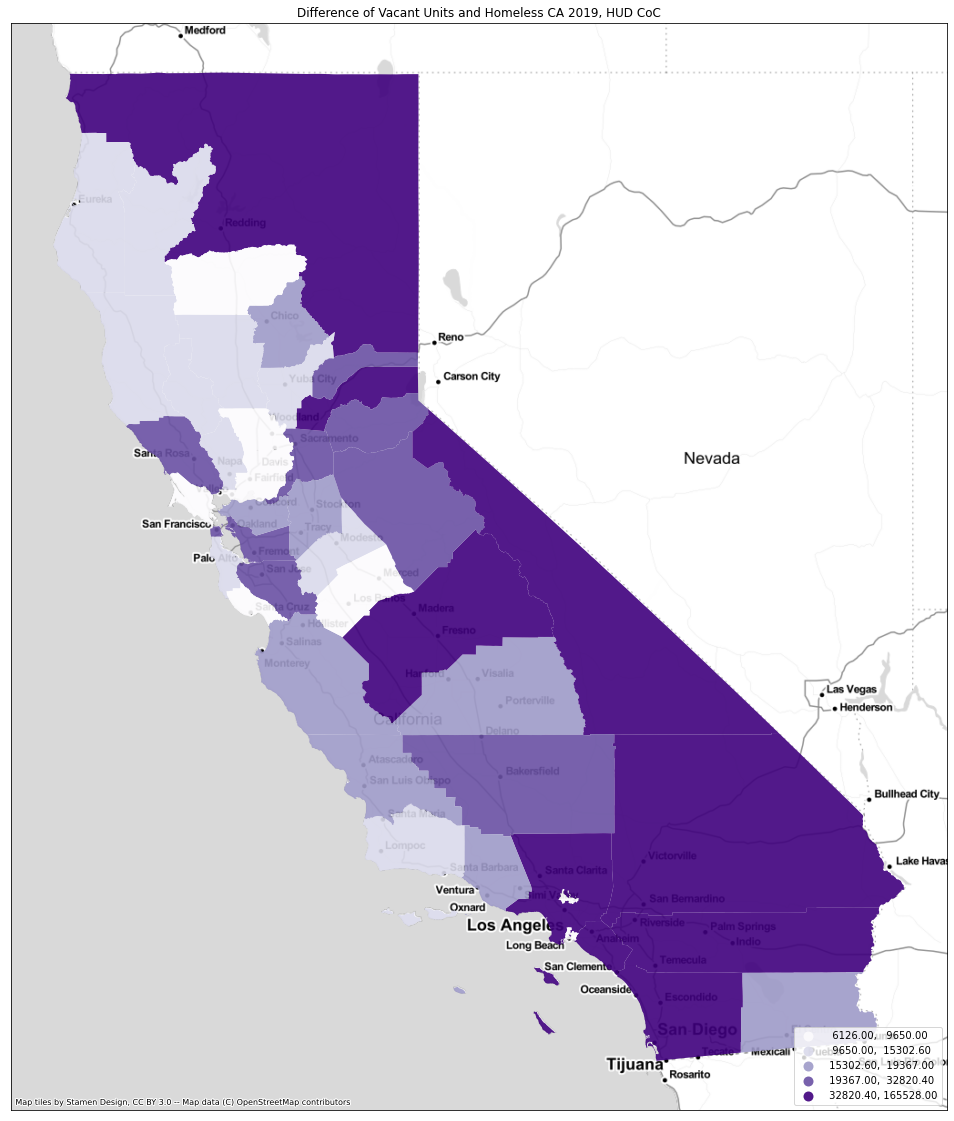

In [100]:
fig, ax = plt.subplots(figsize=(20,20))

calmapgdf.plot('Absolute diff vacancy and total homeless',ax=ax, scheme="Quantiles", k=5, cmap='Purples', alpha=0.9, legend=True,legend_kwds={'loc': 'lower right'})

plt.title('Difference of Vacant Units and Homeless CA 2019, HUD CoC')

ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])


In [101]:
calmapgdf=calmapgdf.set_index('COCNAME')

<AxesSubplot:xlabel='COCNAME'>

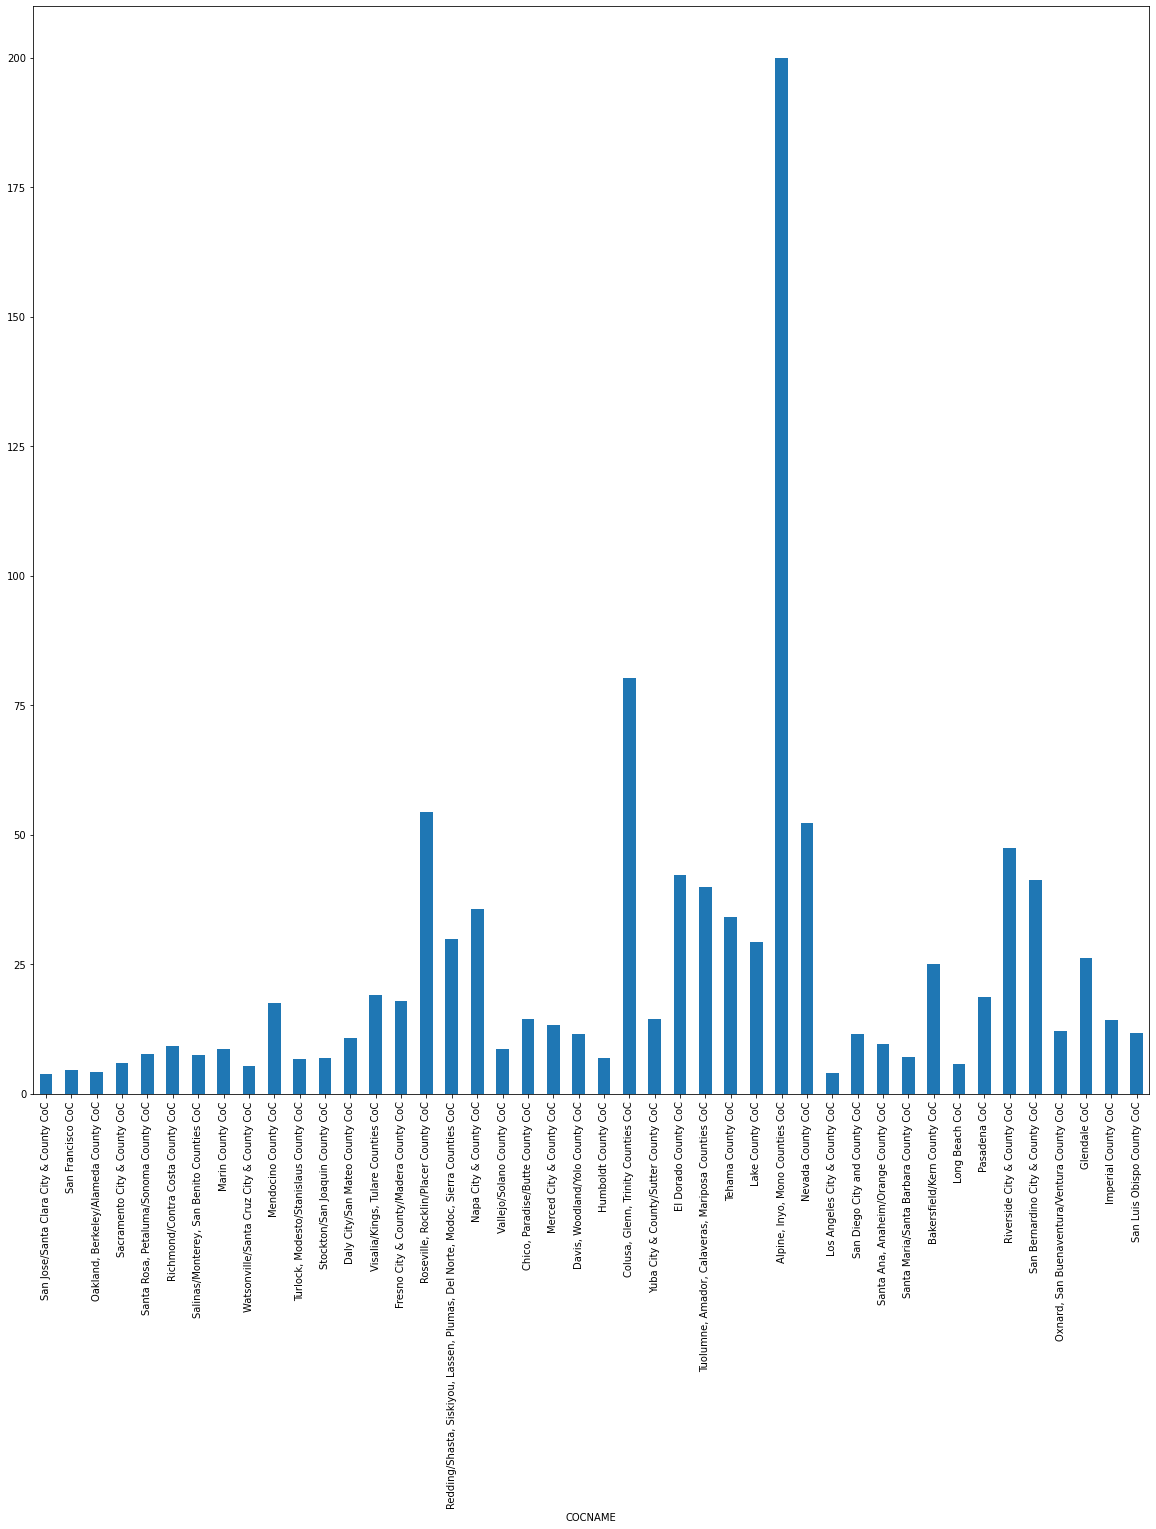

In [102]:
fig, ax = plt.subplots(figsize=(20,20))

calmapgdf['Vacant per total homeless'].plot(kind="bar")

<AxesSubplot:xlabel='COCNAME'>

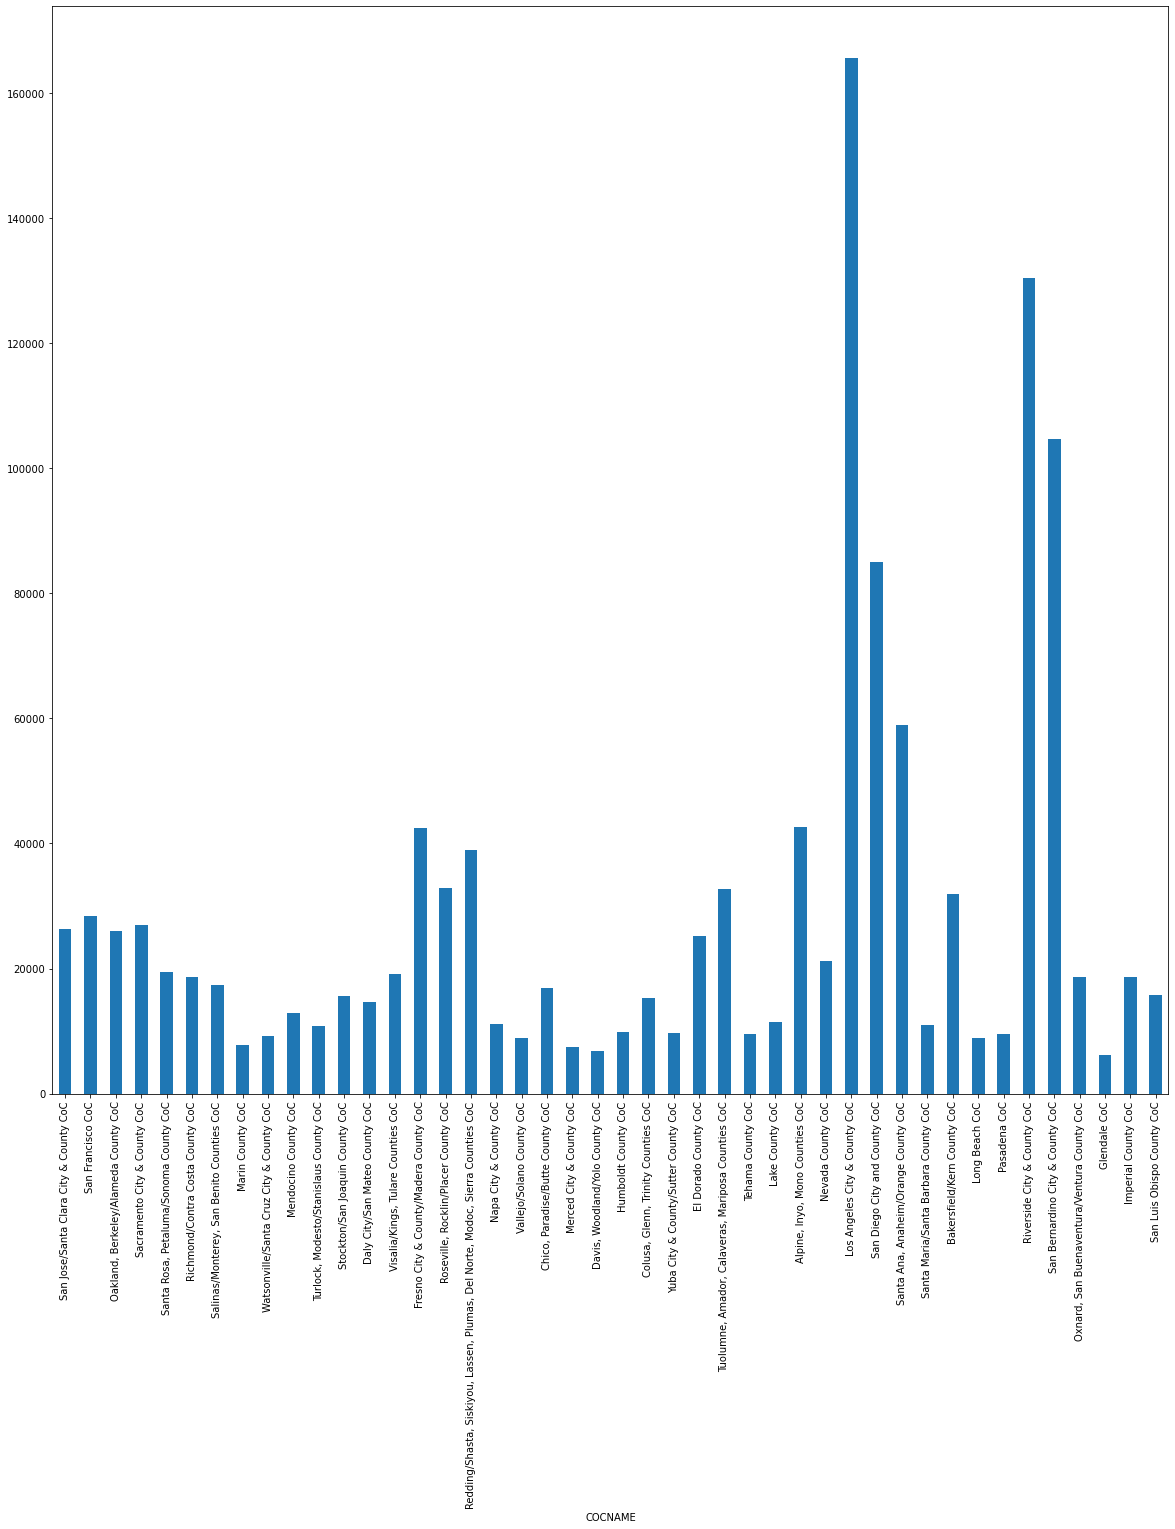

In [103]:
fig, ax = plt.subplots(figsize=(20,20))

calmapgdf['Absolute diff vacancy and total homeless'].plot(kind="bar")


And here is an excercise where these areas are grouped by state.

In [104]:
statesdf=mapgdf.groupby('STATE_NAME')[['Total Population','Total units','Occupied units','Vacant units',
                  'Total vacant', 'For rent', 'Rented, not occupied','For sale only', 'Sold, not occupied',
                  'Other vacant',"Overall Homeless, 2019",'Unsheltered Homeless, 2019' ]].sum()
statesdf.reset_index()

STATE_NAME  Total Population  Total units  Occupied units  \
0                Alabama         5834985.0    2688879.0       2221516.0   
1                 Alaska          764690.0     329516.0        262482.0   
2         American Samoa               0.0          0.0             0.0   
3                Arizona         7649695.0    3280449.0       2786651.0   
4               Arkansas         3711742.0    1723484.0       1428723.0   
5             California        44054949.0   16104024.0      14690761.0   
6               Colorado         6225077.0    2672892.0       2374971.0   
7            Connecticut         3990759.0    1690735.0       1525884.0   
8               Delaware         1135184.0     507856.0        430005.0   
9   District of Columbia          835348.0     376974.0        342460.0   
10               Florida        24031620.0   10859596.0       8846724.0   
11               Georgia        13036407.0    5380990.0       4725162.0   
12                  Guam               0.0          0.0             0.0   
13                Hawaii         1422094.0     542674.0        459424.0   
14                 Idaho         2121751.0     901765.0        777450.0   
15              Illinois        16872216.0    7077643.0       6409169.0   
16               Indiana         7673336.0    3307827.0       2950070.0   
17                  Iowa         3615706.0    1608754.0       1452871.0   
18                Kansas         3320457.0    1452007.0       1287883.0   
19              Kentucky         5305571.0    2360498.0       2061356.0   
20             Louisiana         5677983.0    2537838.0       2110948.0   
21                 Maine         1372087.0     764212.0        575260.0   
22              Maryland         8064103.0    3257945.0       2939099.0   
23         Massachusetts         9463077.0    3960121.0       3601951.0   
24              Michigan        12977897.0    5932707.0       5091287.0   
25             Minnesota         7426584.0    3312600.0       2919481.0   
26           Mississippi         3606199.0    1603555.0       1329883.0   
27              Missouri         8088115.0    3659954.0       3177295.0   
28               Montana         1152573.0     569758.0        469556.0   
29              Nebraska         2405609.0    1050359.0        948613.0   
30                Nevada         3235453.0    1387320.0       1195410.0   
31         New Hampshire         1874849.0     871838.0        734841.0   
32            New Jersey        11396591.0    4582326.0       4124257.0   
33            New Mexico         2693350.0    1184252.0        990581.0   
34              New York        22292038.0    9641489.0       8381291.0   
35        North Carolina        13043455.0    5863798.0       5023192.0   
36          North Dakota          845378.0     415739.0        354405.0   
37     Northern Marianas               0.0          0.0             0.0   
38                  Ohio        13948494.0    6179300.0       5575144.0   
39              Oklahoma         5627108.0    2447059.0       2098965.0   
40                Oregon         5138091.0    2221706.0       2005435.0   
41          Pennsylvania        15581171.0    6931270.0       6133681.0   
42           Puerto Rico         3841199.0    1788228.0       1376211.0   
43          Rhode Island         1172143.0     517894.0        455888.0   
44        South Carolina         5793906.0    2652080.0       2211237.0   
45          South Dakota         1000547.0     458084.0        398194.0   
46             Tennessee         8702754.0    3832718.0       3345154.0   
47                 Texas        32135354.0   12393665.0      10971994.0   
48                  Utah         3544435.0    1269143.0       1117964.0   
49               Vermont          897580.0     475403.0        370847.0   
50        Virgin Islands               0.0          0.0             0.0   
51              Virginia        10845615.0    4579466.0       4061972.0   
52            Washington         828391

In [105]:
statesdf['Vacant per total homeless']=statesdf['Total vacant']/statesdf['Overall Homeless, 2019']

statesdf['Vacant per total unsheltered homeless']=statesdf['Total vacant']/statesdf['Unsheltered Homeless, 2019']

statesdf['Absolute diff vacancy and total homeless']=statesdf['Total vacant']-statesdf['Overall Homeless, 2019']

statesdf['Absolute diff vacancy and total unsheltered homeless']=statesdf['Total vacant']-statesdf['Unsheltered Homeless, 2019']

statesdf = statesdf[statesdf['Overall Homeless, 2019'] != 0]


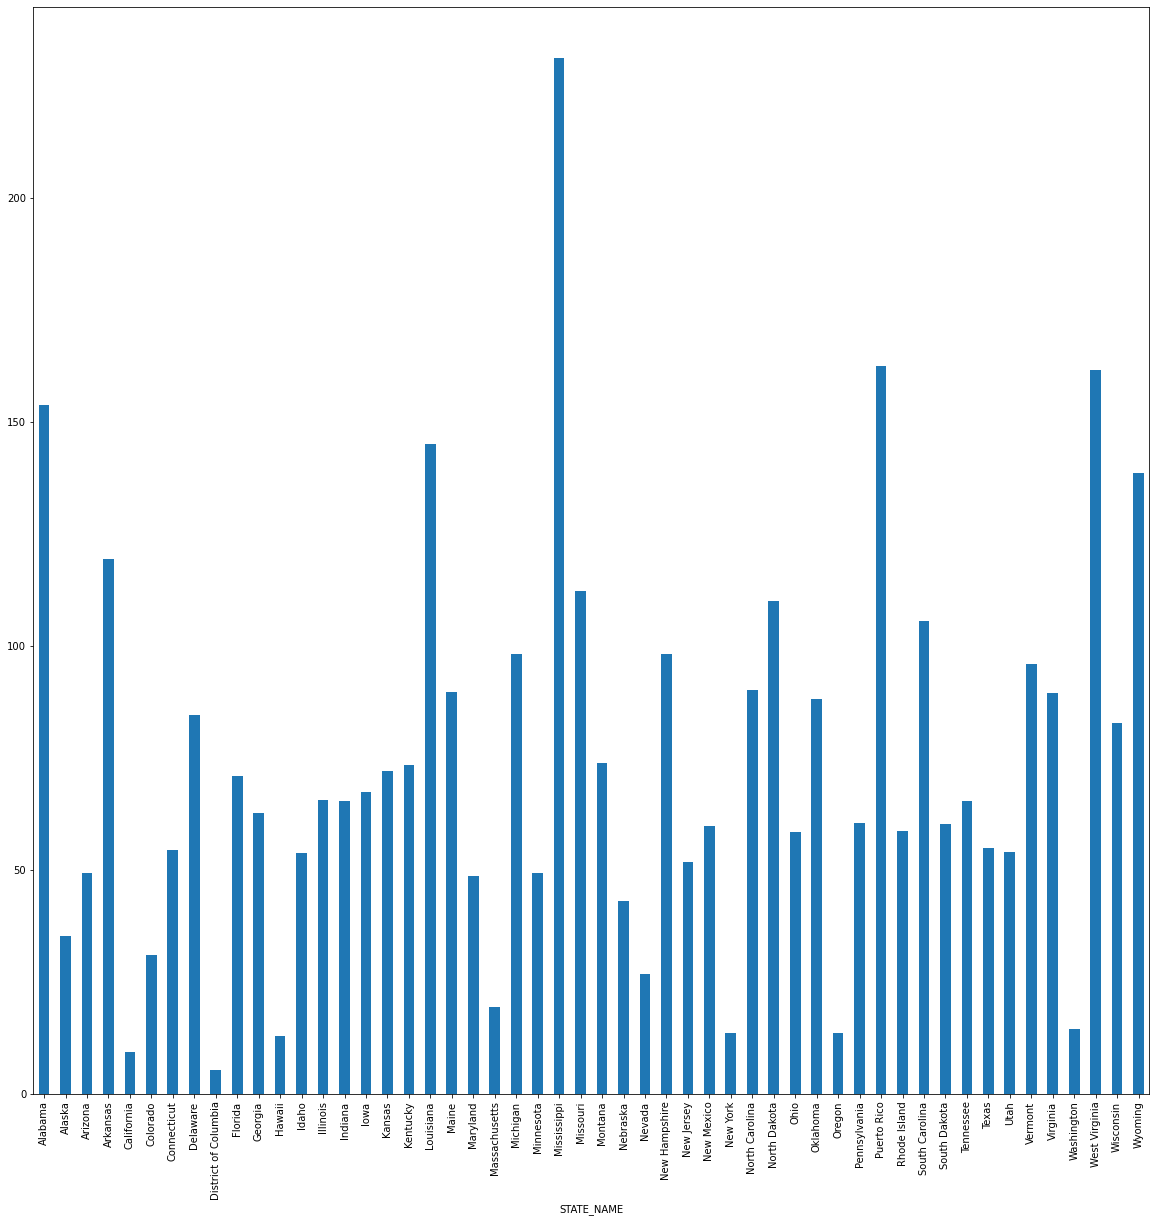

In [106]:
fig, ax = plt.subplots(figsize=(20,20))

statesdf['Vacant per total homeless'].plot(kind="bar")

plt.savefig('/Users/alexanderferrer/Desktop/statevacperhouseless.png')

<AxesSubplot:xlabel='STATE_NAME'>

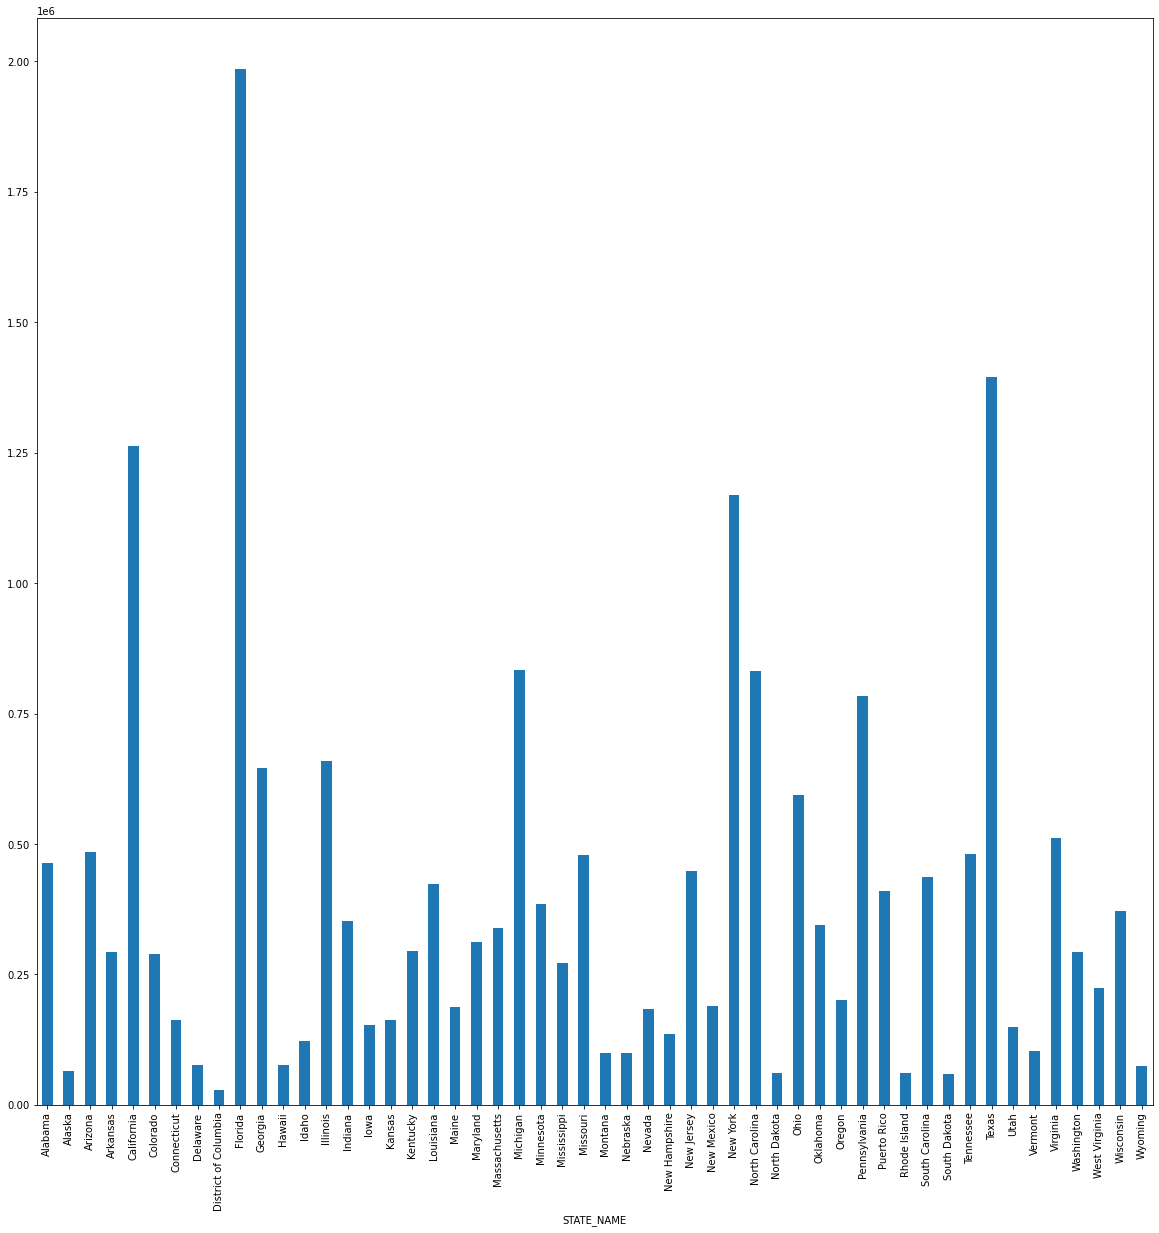

In [107]:
fig, ax = plt.subplots(figsize=(20,20))

statesdf['Absolute diff vacancy and total homeless'].plot(kind="bar")

Learn more about vacancy in Los Angeles:

Perpective: vacancy is a problem: https://www.saje.net/wp-content/uploads/2020/09/The_Vacancy_Report_Final.pdf

Perpective: vacancy is not a problem: https://www.lewis.ucla.edu/research/does-the-los-angeles-region-have-too-many-vacant-homes/